## In this Colab we:
1. import list of latin names (ex. emma, justin etc.)
2. prepare & encode data
    - 'emma' : [e  m  m] -> [a]
    - tensor : [5 13 13] -> [1]
    - split train-dev-test
3. initialize trainable embedding matrix C.shape = [vocab_size(27) , **EMB_SIZE** (2)]
    - map any of 27 letter encodings to its embedding. ex. [0] -> [0.1488, 2.1415]
4. Initialize trainable architecture:
    - h = tanh(BatchNorm[emb @ hidden_W + hidden_b])
    - logits = h @ out_W + out_b
    - F.cross_entropy(logits, Y_true)
5. train for **N_EPOCHS**
6. Compute train & dev loss. Vizualize it

## Result:
- vizualize embeddings (UMAP-reduced to 2D)
- sample new names

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [12]:
WINDOW = 3          # how many previous element to consider

# architecture
EMB_SIZE = 10        # dimention of embedding space
HIDDEN_SIZE = 200   # size of hidden layer

In [13]:
words = open('../docs/names.txt', 'r').read().splitlines()
print(f'{len(words)=}')
words[:7]

len(words)=32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [14]:
# build vocab + vLook-Up tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(chars + ['.'])

In [15]:
# BUILD DATA given WINDOW size

# example 'emma', WINDOW == 3
# context -> output  |  torch.tensor:
#  [...]  -> 'e'     |  [ 0, 0, 0] -> [5]
#  [..e]  -> 'm'     |  [ 0, 0, 5] -> [13]
#  [.em]  -> 'm'     |  [ 0, 5,13] -> [13]
#  [emm]  -> 'a'     |  [ 5,13,13] -> [1]
#  [mma]  -> '.'     |  [13,13, 1] -> [0]


X, Y = [], []

for w in words:

    context = [0] * WINDOW
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix] # update context

X = torch.tensor(X)
Y = torch.tensor(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'Example X[0]: \n{X[0]} -> {Y[0]}\n')
print(f'{X_train.shape=} \n{y_train.shape=}')

Example X[0]: 
tensor([0, 0, 0]) -> 5

X_train.shape=torch.Size([184797, 3]) 
y_train.shape=torch.Size([184797])


### Create simple Embeddings & Neural Network

In [34]:
g = torch.Generator().manual_seed(2147483647)

# BUILD EMBEDDINGS (aka vlook-up)
C = torch.randn((vocab_size,EMB_SIZE),              generator=g)# untrained

# BUILD HIDDEN LAYER
hidden_W=torch.randn((WINDOW*EMB_SIZE, HIDDEN_SIZE),generator=g)# untrained
hidden_b = torch.randn(HIDDEN_SIZE,                 generator=g)# untrained

# BUILD OUT LAYER
out_W = torch.randn((HIDDEN_SIZE, vocab_size),      generator=g)# untrained
out_b = torch.randn(vocab_size,                     generator=g)# untrained

# stable initialization 
init_const = (WINDOW*EMB_SIZE)**0.5 # aka sqrt(N)
hidden_W /= init_const # avoid dead hidden activation
hidden_b /= init_const # avoid dead hidden activation
out_W    /= init_const # avoid over-confident mis-prediction
out_b    *= 0.0        # avoid over-confident mis-prediction

# batch normalization
bn_gain = torch.ones((1, HIDDEN_SIZE))                      # untrained
bn_bias = torch.zeros((1, HIDDEN_SIZE))                     # untrained

bn_mean = torch.zeros((1, HIDDEN_SIZE),requires_grad=False) # non-trainable
bn_std  = torch.ones((1, HIDDEN_SIZE), requires_grad=False) # non-trainable


parameters = [C, hidden_W, hidden_b, out_W, out_b, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True

print('Total number of parameters:')
sum(p.nelement() for p in parameters)

Total number of parameters:


12297

In [32]:
# training params
LR = 0.1
N_EPOCHS = 200000
BATCH_SIZE = 32

loglossi = []
first_init = False

for epoch in range(2):

    # -------- Forward-pass ---------------

    # mini batch
    ixs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,),generator=g)

    # train embeddings
    emb = C[X_train[ixs]]                          # (N, 3, 2)
    emb = emb.view(-1, WINDOW*EMB_SIZE) #  concat by tokens -> (N , 6) 

    # train Hidden Layer
    #   1. sum func
    z = emb @ hidden_W + hidden_b
    #   2. batch norm
    z_mean = z.mean(0, keepdim=True)
    z_std = z.std(0, keepdim=True)
    z = bn_gain * (z - z_mean) / z_std + bn_bias
    with torch.no_grad(): # update running batch-norm mean & std (for inference)
        bn_mean = 0.999 * bn_mean + 0.001 * z_mean
        bn_std  = 0.999 * bn_std  + 0.001 * z_std

    #   3. non-linearity
    h = torch.tanh(z)

    # train Output Layer
    logits = h @ out_W + out_b

    # compute the loss
    loss = F.cross_entropy(logits, y_train[ixs])

    loglossi.append(loss.log10().item())
    if not first_init:
        with torch.no_grad():
            first_init = True
            z_tgt = z.view(-1).tolist()
            h_tgt = h.view(-1).tolist()
            loss0_tgt = loss.item()

            _h_ref = torch.tanh(emb @ hidden_W * init_const + hidden_b * init_const)
            h_ref = _h_ref.view(-1).tolist()

            logits_ref= _h_ref @ out_W * init_const + out_b
            loss0_ref = F.cross_entropy(logits_ref, y_train[ixs])
    
    # training
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = LR if epoch < N_EPOCHS//2 else 0.1 * LR

    #update
    for p in parameters:
        p.data += -lr * p.grad

## Motivation N.1 :
**Dead hidden activation -> SLOW initial learning**

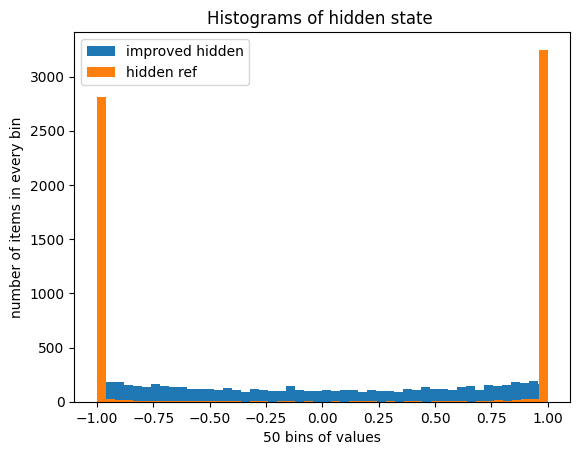

In [33]:
plt.hist(h_tgt, 50, label='improved hidden')
plt.hist(h_ref, 50, label='hidden ref')
# plt.hist(z_tgt, 50, label='sum func z')
plt.title('Histograms of hidden state ')
plt.xlabel('50 bins of values')
plt.ylabel('number of items in every bin')
plt.legend()

## Motivation N.2 :
**Over-condifent mis-prediction -> HIGH initial loss**

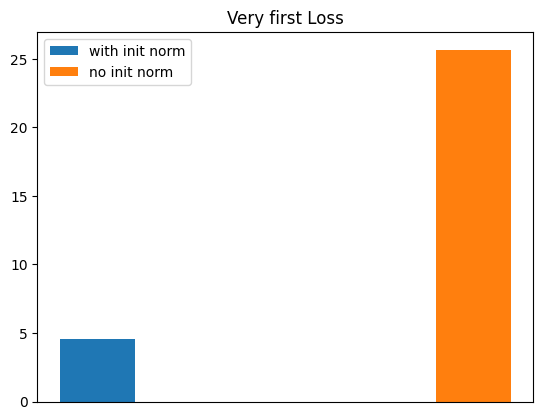

In [129]:
plt.bar(0, loss0_tgt, width=0.2, label='with init norm')
plt.bar(1,loss0_ref, width=0.2, label='no init norm')
plt.xticks([], [])
plt.title('Very first Loss')
plt.legend()


## Motivation N.3 :
**Dot-product of two Standard Norm Dist -> EXPENDED Dist**

Text(0.5, -0.5, 'Result: for Stability Normalize Weights by $\\sqrt{N}$')

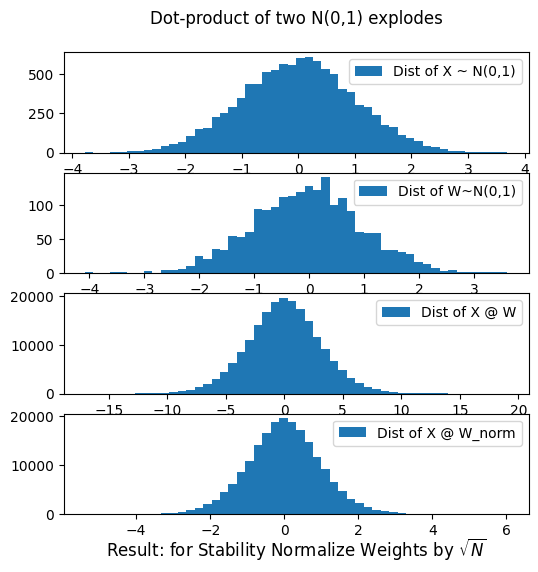

In [139]:
# Consider other example:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
w_norm = w / 10**0.5
y = x @ w

plt.figure(figsize=(6,6))
plt.subplot(411)
plt.hist(x.view(-1).tolist(), 50, label='Dist of X ~ N(0,1)');plt.legend()
plt.title('Dot-product of two N(0,1) explodes', y=1.2)
plt.subplot(412)
plt.hist(w.view(-1).tolist(), 50, label='Dist of W~N(0,1)');plt.legend()
plt.subplot(413)
plt.hist(y.view(-1).tolist(), 50, label='Dist of X @ W');plt.legend()

y_norm = x @ w_norm
plt.subplot(414)
plt.hist(y_norm.view(-1).tolist(), 50, label='Dist of X @ W_norm')
plt.legend()
plt.title('Result: for Stability Normalize Weights by $\\sqrt{N}$', y=-.5)

In [131]:
# compute loss score
@torch.no_grad()
def get_loss(split):
    assert split in ['train', 'dev', 'test'], f'{split} not yet supported'
    x,y = {
        'train' : (X_train, y_train),
        'dev'   : (X_dev, y_dev),
        'test'  : (X_test, y_test)
    }[split]

    emb = C[x]
    emb = emb.view(-1, WINDOW * EMB_SIZE)
    h = torch.tanh(emb @ hidden_W + hidden_b)
    logits = h @ out_W + out_b
    loss = F.cross_entropy(logits, y)
    print(f'{split}{loss.item()=}')


get_loss('train')
get_loss('dev')
# best train (2.03) best dev (2.10)

trainloss.item()=2.0350077152252197
devloss.item()=2.105480670928955


In [132]:
# Sample

for _ in range(20):

    out = []
    context = [0] * WINDOW
    while True:
        emb = C[torch.tensor(context)]
        emb = emb.view(1, -1)
        h = torch.tanh(emb @ hidden_W + hidden_b)
        logits = h @ out_W + out_b
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

wiler.
keyler.
aaro.
covton.
farathaya.
kheilida.
khariel.
poetu.
bas.
xar.
sri.
koeregg.
korritt.
ceceren.
makin.
madali.
yurletizheer.
delothavla.
faory.
emid.


## Extra notes

### BatchNorm
- at the very first pass, hidden sum func (z) is exactly ~ N(0,1)
- then NN learns the gain and bias of BatchNorm aka ~N(batchnorm_gain, bathcnorm_bias)
- mathematically, update of one particular neuron depends on other neurons in the given batch
    - it also creates gradient leakage as substract-divide (aka norm) is differentiatiable.
- in PyTorch, torch.BatchNorm internally keeps track of "running" mean and std, so don't forget to model.eva() during inference.
- for Linear layer (z = emb @ W + b), bias (b) becomes useless as we normalize (z) afterwards. So drop it off from architecture.